In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import numpy as np
import physics as phys
import utilities as utils
import spectrum
import transferfunction as tf
import matplotlib
import matplotlib.pyplot as plt
import pickle

matplotlib.rcParams['figure.figsize'] = [10,10]


from scipy import integrate
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm

In [3]:
transfer_func_table = pickle.load(open(
    "/Users/hongwan/Dropbox (MIT)/Photon Deposition/transfer_func_table.raw", "rb")
)

In [4]:
eng = np.array([transfer_func.in_eng 
                for transfer_func in transfer_func_table])
tf_rs_arr = np.array([spec.rs for spec in transfer_func_table[0]])

In [5]:
# Transfer function is normalized to 1 particle in the bin.
# To use the transfer function on dN/dE, need to further normalize.
norm_spec = spectrum.rebin_N_arr(np.ones(eng.size), eng, eng)

In [6]:
#Initialize
eng_ind = 298
mwimp = eng[eng_ind]
print(mwimp)

rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[20]), 
                           -0.002)
                )

# Initial injection is 2 photons, to match up with what we have in file.
photon_spec_init = spectrum.rebin_N_arr(np.array([2]), 
                                        np.array([mwimp]), 
                                        eng)
                                       
photon_spec_init.rs = rs_list[0]

1016521483.17


In [7]:
print(np.log(tf_rs_arr[0]))
print(np.log(tf_rs_arr[1]))

3.43398720449
3.39303334762


In [8]:
photon_spectra = spectrum.Spectra([photon_spec_init])
append = photon_spectra.append

# List of transfer functions interpolated at rs_list, indexed by injection energy.
# Perform the normalization properly. 
tf_at_rs_list = [transfer_func.at_rs(rs_list)/norm_spec.dNdE[i]
                 for i,transfer_func in 
                 zip(np.arange(norm_spec.length), tqdm(transfer_func_table))]


In [9]:
for i in tqdm(np.arange(rs_list.size-1).astype(int)):
    tf_at_rs = spectrum.Spectra([transfer_func[i]
                             for transfer_func in tf_at_rs_list])
    append(tf_at_rs.sum_specs(photon_spectra[-1]))
    photon_spectra[-1].rs = rs_list[i+1]


In [10]:
file_name = {99: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
            199: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
            298: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
            299: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits", 
            399: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
            499: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits"}

file = fits.open(file_name[eng_ind])

file_eng = file[1].data['energy'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]

In [11]:
# file_spectra = spectrum.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
#                    for photspec,rs in zip(file_photonspectrum, file_rs)], 
#                 rebin_eng = eng)

file_spectra = spectrum.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)])

In [12]:
file_spectra.rebin(photon_spectra.eng)

30.1440393708
30.8145568857


[100000000.0, 100000000000.0, 1e-18, 1e-08]

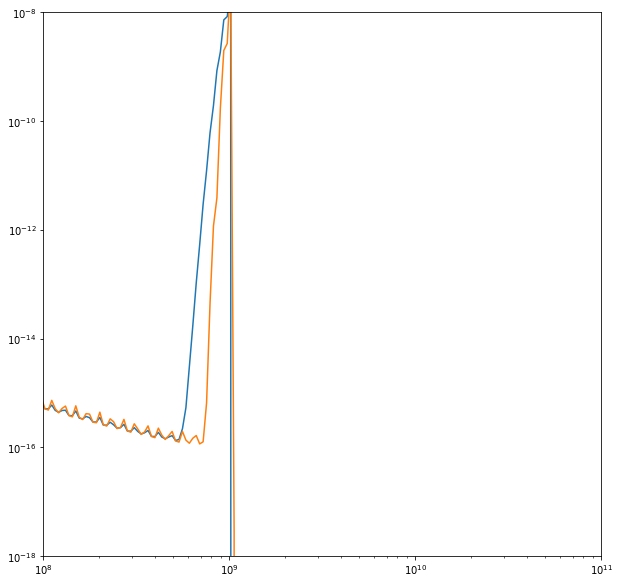

In [42]:
i=14
j=6
print(photon_spectra[i].rs)
print(file_spectra[j].rs)

ax = plt.subplot(1,1,1)
plt.plot(photon_spectra.eng, photon_spectra[i].dNdE)
plt.plot(photon_spectra.eng, file_spectra[j].dNdE)
# plt.plot(file_spectra[j].eng, file_spectra[j].dNdE)

# plt.plot(photon_spectra.eng, photon_spectra[i].totN('bin',np.arange(501)))
# plt.plot(file_spectra[j].eng, file_spectra[j].totN('bin',np.arange(501)))
ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([1e8, 1e11, 1e-18, 1e-8])
# b = file_spectra.plot(2)
# axb = b.add_subplot(1,1,1)
# axb.set_xscale('log')
# axb.set_yscale('log')


In [14]:
np.set_printoptions(threshold=np.nan)
print(eng[eng_ind])
utils.compare_arr([photon_spectra[i].eng,
                   photon_spectra[i].dNdE,
#                    file_spectra[j].eng,
                   file_spectra[j].dNdE, 
                   ])

1016521483.17
[[  3.07055574e+03   3.12906717e-02   4.10348497e-02]
 [  3.21164413e+03   2.74005100e-02   2.75886540e-02]
 [  3.35924860e+03   2.60014561e-02   2.45297261e-02]
 [  3.51367319e+03   2.49059549e-02   2.28876152e-02]
 [  3.67523644e+03   1.78269150e-02   6.16513781e-02]
 [  3.67612926e+03   2.92713061e-02   0.00000000e+00]
 [  3.84524889e+03   2.05779606e-02   2.08263824e-02]
 [  4.02219842e+03   1.95092416e-02   1.84226157e-02]
 [  4.20734499e+03   1.86116837e-02   1.71673544e-02]
 [  4.40107337e+03   1.76309560e-02   2.29450845e-02]
 [  4.60378687e+03   1.53475167e-02   1.56080051e-02]
 [  4.81590825e+03   1.45465361e-02   1.37468487e-02]
 [  5.03788072e+03   1.38314348e-02   1.27976085e-02]
 [  5.27016899e+03   1.31029295e-02   1.69006158e-02]
 [  5.51326034e+03   1.13910599e-02   1.17152868e-02]
 [  5.76766581e+03   1.07881569e-02   1.02030263e-02]
 [  6.03392139e+03   1.02124161e-02   9.49025572e-03]
 [  6.31258935e+03   9.68627943e-03   1.23027354e-02]
 [  6.60425955

0

In [15]:
np.set_printoptions(threshold=np.nan)
print(eng[eng_ind])
utils.compare_arr([photon_spectra[i].eng,
                   photon_spectra[i].totN('eng', photon_spectra[i].bin_boundary),
                   file_spectra[j].totN('eng', photon_spectra[i].bin_boundary) 
                   ])

1016521483.17
[[  3.07055574e+03   4.31632770e+00   5.66046840e+00]
 [  3.21164413e+03   3.95381576e+00   3.98096440e+00]
 [  3.35924860e+03   3.92525610e+00   3.70307943e+00]
 [  3.51367319e+03   3.93364343e+00   3.61486711e+00]
 [  3.67523644e+03   1.48065673e+00   5.12060150e+00]
 [  3.67612926e+03   2.43299782e+00   0.00000000e+00]
 [  3.84524889e+03   3.55947617e+00   3.60244697e+00]
 [  4.02219842e+03   3.53089580e+00   3.33423193e+00]
 [  4.20734499e+03   3.52453649e+00   3.25102060e+00]
 [  4.40107337e+03   3.49361964e+00   4.54662798e+00]
 [  4.60378687e+03   3.18224325e+00   3.23625442e+00]
 [  4.81590825e+03   3.15618880e+00   2.98267915e+00]
 [  5.03788072e+03   3.14045038e+00   2.90571839e+00]
 [  5.27016899e+03   3.11335179e+00   4.01570982e+00]
 [  5.51326034e+03   2.83252272e+00   2.91314559e+00]
 [  5.76766581e+03   2.80750808e+00   2.65523379e+00]
 [  6.03392139e+03   2.78152160e+00   2.58482919e+00]
 [  6.31258935e+03   2.76126110e+00   3.50713243e+00]
 [  6.60425955

0

In [16]:
tf_rs_31 = spectrum.Spectra([transfer_func[0] for transfer_func in tf_at_rs_list])

[1000.0, 200000000000.0, 1e-20, 1000.0]

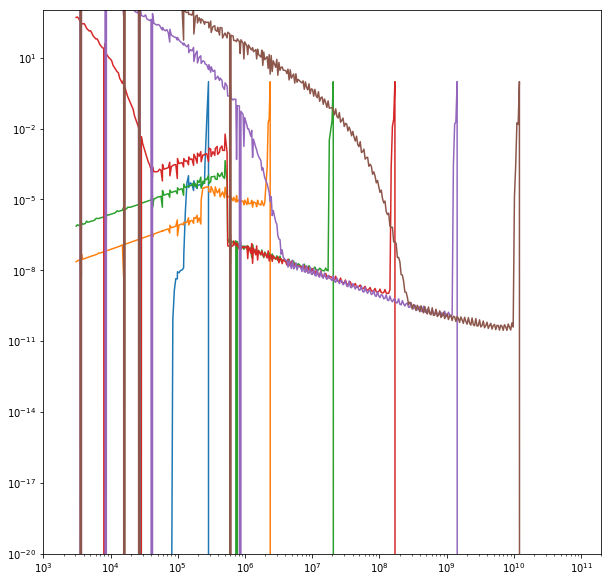

In [17]:
a_fig = tf_rs_31.plot((106, 399),step=50)
a = a_fig.get_axes()[0]
a.set_xscale('log')
a.set_yscale('log')
plt.axis([1e3, 2e11, 1e-20, 1e3])